In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import psycopg2
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import chi2_contingency
from scipy.stats import stats
from scipy.stats import f_oneway
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401, needed for 3d projection

In [3]:
class insurance_analysis:
    def __init__(self, insu):
        """
        Initialize with an insurance DataFrame.
        
        Parameters:
        insu (pd.DataFrame): The insurance claims dataset loaded as a DataFrame.
        """
        self.insu = insu

    def data_frame(self):
        """
        Return the raw insurance DataFrame for external analysis.
        
        Returns:
        pd.DataFrame: The insurance DataFrame.
        """
        return self.insu

    def info(self):
        """
        Print information about the DataFrame including column types and non-null counts.
        
        Returns:
        None
        """
        return self.insu.info()

    def null_values(self):
        """
        Count the number of missing (null) values in each column of the DataFrame.
        
        Returns:
        pd.Series: Number of nulls per column.
        """
        return self.insu.isnull().sum()

    def fill_the_null_values(self):
        """
        Fill up to 91 null values in the DataFrame with the string 'Fire'.
        Then return the mean of the counts of unique values in the 'authorities_contacted' column.
        
        Returns:
        float: Mean of value counts in 'authorities_contacted' after fill.
        """
        self.insu.fillna('Fire', limit=91, inplace=True)
        return self.insu['authorities_contacted'].value_counts().mean()

    def filter_fraud_claims(self):
        """
        Filter the DataFrame to include only fraudulent claims (where 'fraud_reported' == 'Y').
        Stores the filtered DataFrame in self.fraud_claims.
        
        Raises:
        ValueError: If self.insu is None.
        """
        if self.insu is None:
            raise ValueError("Data not loaded. Call load_data() first.")
        self.fraud_claims = self.insu[self.insu['fraud_reported'] == 'Y']

    def calculate_average_fraud_claim(self):
        """
        Calculate the average total claim amount for fraudulent claims.
        
        Returns:
        float: Mean of 'total_claim_amount' for filtered fraudulent claims.
        
        Raises:
        ValueError: If fraud claims have not been filtered yet.
        """
        if not hasattr(self, 'fraud_claims') or self.fraud_claims is None:
            raise ValueError("Fraud claims not filtered. Call filter_fraud_claims() first.")
        return self.fraud_claims['total_claim_amount'].mean()

    def run_fraud_analysis(self):
        """
        Run the fraud analysis by filtering fraudulent claims and calculating their average claim amount.
        
        Returns:
        float: Average total claim amount for fraudulent claims.
        """
        self.filter_fraud_claims()
        return self.calculate_average_fraud_claim()

    def fraud_count(self):
        """
        Get the count of claims by fraud reported status.
        
        Returns:
        pd.DataFrame: Counts of values in 'fraud_reported' column with reset index.
        """
        return self.insu['fraud_reported'].value_counts().reset_index()

    def mercedes_claim_amount(self):
        """
        Calculate the total claim amount for Mercedes vehicle claims.
        
        Returns:
        float: Sum of 'total_claim_amount' where 'auto_make' is 'Mercedes'.
        """
        return self.insu[self.insu['auto_make'] == 'Mercedes']['total_claim_amount'].sum()

    def male_female_fraud(self):
        """
        Get the count of fraudulent claims grouped by the insured person's sex.
        
        Returns:
        pd.DataFrame: Count of fraud claims per 'insured_sex' with reset index.
        """
        return self.insu[self.insu['fraud_reported'] == 'Y'].groupby('insured_sex').size().reset_index(name='count')

    def top_incident_type(self):
        """
        Get counts of each 'incident_type' in the dataset.
        
        Returns:
        pd.DataFrame: Counts of incident types with reset index.
        """
        return self.insu['incident_type'].value_counts().reset_index()

    def Chi_Square_test(self, col1, col2):
        """
        Perform Chi-Square test of independence between two categorical columns.
        
        Parameters:
        col1 (str): Name of the first categorical column.
        col2 (str): Name of the second categorical column.
        
        Returns:
        dict: Chi-square statistic, p-value, degrees of freedom, and expected frequencies.
        """
        contingency_table = pd.crosstab(self.insu[col1], self.insu[col2])
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        return {
            'chi2_statistic': chi2,
            'p_value': p,
            'degrees_of_freedom': dof,
            'expected_freq': expected
        }

    def plot_numeric_correlation(self, figsize=(15, 12), cmap='coolwarm'):
        """
        Plot a heatmap of correlation matrix among numerical columns in the dataset.
        
        Parameters:
        figsize (tuple): Figure size (width, height).
        cmap (str): Color map for the heatmap.
        
        Returns:
        None
        """
        numeric_df = self.insu.select_dtypes(include=np.number)
        corr = numeric_df.corr()
        plt.figure(figsize=figsize)
        sns.heatmap(corr, annot=True, cmap=cmap)
        plt.show()    

    def ANOVA(self):
        """
        Perform ANOVA test on all numeric columns grouped by 'fraud_reported' to identify differences.
        Prints F-statistic and p-values for each numeric variable.
        
        Returns:
        None
        """
        continuous_vars = self.insu.select_dtypes(['int64', 'float64']).columns.tolist()
        target = 'fraud_reported'
        for col in continuous_vars:
            data = self.insu[[col, target]].dropna()
            groups = [group[col].values for name, group in data.groupby(target)]
            f_stat, p_val = stats.f_oneway(*groups)
            print(f"ANOVA for {col} by {target}: F = {f_stat:.3f}, p = {p_val:.3e}")

    def bar_graph(self):
        """
        Plot a bar chart showing count of claims per incident city.
        
        Returns:
        matplotlib.axes.Axes: The seaborn barplot axes object.
        """
        top_cities = self.insu['incident_city'].value_counts()
        plt.figure(figsize=(10, 5))
        ax = sns.barplot(x=top_cities.index, y=top_cities.values)
        plt.xticks(rotation=90)
        plt.title("Claims by Incident City")
        plt.xlabel("Incident City")
        plt.ylabel("Claim Count")
        plt.tight_layout()
        plt.show()
        return ax

    def plot_boxplot_auto_year_by_make(self):
        """
        Plot a boxplot comparing 'total_claim_amount' across different 'auto_make' categories.
        
        Returns:
        None
        """
        plt.figure(figsize=(16, 12))  # Fixed figure size
        sns.boxplot(x=self.insu['auto_make'], y=self.insu['total_claim_amount'])
        plt.xticks(rotation=90)        # Fixed rotation angle
        plt.xlabel('Auto Make')
        plt.ylabel('Total Claim Amount')
        plt.title('Boxplot of Total Claim Amount by Auto Make')
        plt.tight_layout()
        plt.show()

    def plot_violin_policy_state_vs_deductable(self):
        """
        Plot a violin plot of 'policy_state' vs 'policy_deductable'.
        
        Returns:
        None
        """
        plt.figure(figsize=(12, 6))
        sns.violinplot(x=self.insu['policy_state'], y=self.insu['policy_deductable'])
        plt.title('Violin Plot: Policy State vs Policy Deductable')
        plt.show()

    def plot_scatter_capital_gains_vs_loss(self):
        """
        Plot a scatterplot to visualize 'capital-gains' against 'capital-loss'.
        
        Returns:
        None
        """
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=self.insu['capital-gains'], y=self.insu['capital-loss'])
        plt.title('Scatter Plot: Capital Gains vs Capital Loss')
        plt.show()

    def plot_3d_scatter_claims(self):
        """
        Plot a 3D scatter plot of 'injury_claim', 'property_claim', and 'vehicle_claim',
        with coloring based on 'property_claim'.
        
        Returns:
        None
        """
        fig = px.scatter_3d(self.insu,
                            x='injury_claim',
                            y='property_claim',
                            z='vehicle_claim',
                            color='property_claim',
                            title='3D Scatter Plot: Injury, Property and Vehicle Claims')
        fig.show()

    def plot_vehicle_make_pie(self):
        """
        Plot a pie chart showing the distribution of vehicle makes in the dataset.
        
        Returns:
        None
        """
        vehicle_counts = self.insu['auto_make'].value_counts()
        plt.figure(figsize=(8, 8))
        vehicle_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, shadow=True)
        plt.title("Vehicle Types")
        plt.ylabel("")  # Hide y-axis label
        plt.show()
    def histogram(self, col_name, title=None):
        sns.histplot(data=self.insu, x=col_name, bins=20)
        if title:
            plt.title(title)
        else:
            plt.title(f'Distribution of {col_name}')
        plt.show()

    def plot_fraud_by_sex_and_education(self):
        # Plot count of Fraud Reported grouped by Sex, faceted by Education level
        g = sns.catplot(
            data=self.insu,
            x='insured_sex', 
            hue='fraud_reported',
            col='insured_education_level', 
            kind='count',
            col_wrap=4,  # Adjust number of columns per row for layout
            height=4,
            aspect=1
        )
        g.fig.suptitle('Count of Fraud Reported by Sex and Education Level', y=1.03)
        plt.show()

    @staticmethod
    def infer_sql_type(dtype):
        if pd.api.types.is_integer_dtype(dtype):
            return "INT"
        elif pd.api.types.is_float_dtype(dtype):
            return "FLOAT"
        elif pd.api.types.is_bool_dtype(dtype):
            return "BOOLEAN"
        elif pd.api.types.is_datetime64_any_dtype(dtype):
            return "TIMESTAMP"
        else:
            return "TEXT"

    def generate_create_table_statement(self, table_name="insurance_claims"):
        """
        Generates SQL CREATE TABLE statement based on DataFrame column dtypes.
        
        Parameters:
        -----------
        table_name : str
            Name of the SQL table to create.
        
        Returns:
        --------
        str
            SQL CREATE TABLE statement.
        """
        columns = self.insu.dtypes
        sql_columns = ",\n    ".join([f'"{col}" {self.infer_sql_type(dtype)}' for col, dtype in columns.items()])
        create_stmt = f"""
    CREATE TABLE IF NOT EXISTS {table_name} (
        {sql_columns}
    );
    """
        return create_stmt

    def save_to_postgres(self, conn_params, table_name="insurance_claims"):
        """
        Creates table and inserts DataFrame records into PostgreSQL.
        
        Parameters:
        -----------
        conn_params : dict
            Dictionary with keys: dbname, user, password, host, port.
        table_name : str, optional
            Name of the PostgreSQL table, default "Ecommerce_Delivery_Analytics_New".
        """
        create_stmt = self.generate_create_table_statement(table_name)
        
        try:
            conn = psycopg2.connect(**conn_params)
            cur = conn.cursor()
            
            # Create the table
            cur.execute(create_stmt)
            conn.commit()
            
            # Prepare insert statement
            columns = list(self.insu.columns)
            placeholders = ', '.join(['%s'] * len(columns))
            insert_stmt = f"""
            INSERT INTO {table_name} ({', '.join(['"{}"'.format(col) for col in columns])})
            VALUES ({placeholders})
            """
            
            # Insert data row by row
            for _, row in self.insu.iterrows():
                cur.execute(insert_stmt, tuple(row))
            conn.commit()
            
            cur.close()
            conn.close()
            print(f"Data inserted successfully into table {table_name}")
            
        except Exception as e:
            print(f"Error during PostgreSQL operation: {e}")

# Load data
insu = pd.read_csv('insurance_claims.csv')

# Initialize the analysis class
insu_data = insurance_analysis(insu)
insu_data.data_frame()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,17-10-2014,OH,250/500,1000,1406.91,0,466132,...,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,342868,27-06-2006,IN,250/500,2000,1197.22,5000000,468176,...,0,?,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,687698,06-09-2000,OH,100/300,2000,1413.14,5000000,430632,...,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,227811,25-05-1990,IL,250/500,2000,1415.74,6000000,608117,...,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,44,367455,06-06-2014,IL,500/1000,1000,1583.91,6000000,610706,...,1,NO,6500,1300,650,4550,Accura,RSX,2009,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,38,941851,16-07-1991,OH,500/1000,1000,1310.80,0,431289,...,1,?,87200,17440,8720,61040,Honda,Accord,2006,N
996,285,41,186934,05-01-2014,IL,100/300,1000,1436.79,0,608177,...,3,?,108480,18080,18080,72320,Volkswagen,Passat,2015,N
997,130,34,918516,17-02-2003,OH,250/500,500,1383.49,3000000,442797,...,3,YES,67500,7500,7500,52500,Suburu,Impreza,1996,N
998,458,62,533940,18-11-2011,IL,500/1000,2000,1356.92,5000000,441714,...,1,YES,46980,5220,5220,36540,Audi,A5,1998,N


In [4]:
insu_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1000 non-null   int64  
 1   age                          1000 non-null   int64  
 2   policy_number                1000 non-null   int64  
 3   policy_bind_date             1000 non-null   object 
 4   policy_state                 1000 non-null   object 
 5   policy_csl                   1000 non-null   object 
 6   policy_deductable            1000 non-null   int64  
 7   policy_annual_premium        1000 non-null   float64
 8   umbrella_limit               1000 non-null   int64  
 9   insured_zip                  1000 non-null   int64  
 10  insured_sex                  1000 non-null   object 
 11  insured_education_level      1000 non-null   object 
 12  insured_occupation           1000 non-null   object 
 13  insured_hobbies    

In [5]:
insu_data.null_values()

months_as_customer              0
age                             0
policy_number                   0
policy_bind_date                0
policy_state                    0
policy_csl                      0
policy_deductable               0
policy_annual_premium           0
umbrella_limit                  0
insured_zip                     0
insured_sex                     0
insured_education_level         0
insured_occupation              0
insured_hobbies                 0
insured_relationship            0
capital-gains                   0
capital-loss                    0
incident_date                   0
incident_type                   0
collision_type                  0
incident_severity               0
authorities_contacted          91
incident_state                  0
incident_city                   0
incident_location               0
incident_hour_of_the_day        0
number_of_vehicles_involved     0
property_damage                 0
bodily_injuries                 0
witnesses     

In [6]:
insu_data.fill_the_null_values()

np.float64(250.0)

In [7]:
insu_data.null_values()

months_as_customer             0
age                            0
policy_number                  0
policy_bind_date               0
policy_state                   0
policy_csl                     0
policy_deductable              0
policy_annual_premium          0
umbrella_limit                 0
insured_zip                    0
insured_sex                    0
insured_education_level        0
insured_occupation             0
insured_hobbies                0
insured_relationship           0
capital-gains                  0
capital-loss                   0
incident_date                  0
incident_type                  0
collision_type                 0
incident_severity              0
authorities_contacted          0
incident_state                 0
incident_city                  0
incident_location              0
incident_hour_of_the_day       0
number_of_vehicles_involved    0
property_damage                0
bodily_injuries                0
witnesses                      0
police_rep

In [9]:
insu_data.filter_fraud_claims()

In [10]:
insu_data.calculate_average_fraud_claim()

np.float64(60302.10526315789)

In [11]:
insu_data.run_fraud_analysis()

np.float64(60302.10526315789)

In [12]:
avg_fraud_claim = insu_data.run_fraud_analysis()
print("Average Total Claim Amount for Fraudulent Claims:", avg_fraud_claim)

Average Total Claim Amount for Fraudulent Claims: 60302.10526315789


In [13]:
insu_i.fraud_count()

,fraud_reported,count
0,N,753
1,Y,247


In [14]:
insu_data.mercedes_claim_amount()

np.int64(3404190)

In [15]:
insu_data.male_female_fraud()

,insured_sex,count
0,FEMALE,126
1,MALE,121


In [16]:
insu_data.top_incident_type()

,incident_type,count
0,Multi-vehicle Collision,419
1,Single Vehicle Collision,403
2,Vehicle Theft,94
3,Parked Car,84


In [17]:
insu_data.Chi_Square_test("policy_state","incident_state")

{'chi2_statistic': np.float64(10.372757213092454),
 'p_value': np.float64(0.5832944299573612),
 'degrees_of_freedom': 12,
 'expected_freq': array([[37.18 , 88.556,  7.774, 10.14 , 83.824, 37.18 , 73.346],
        [34.1  , 81.22 ,  7.13 ,  9.3  , 76.88 , 34.1  , 67.27 ],
        [38.72 , 92.224,  8.096, 10.56 , 87.296, 38.72 , 76.384]])}

In [18]:
insu_i.ANOVA()

ANOVA for months_as_customer by fraud_reported: F = 0.421, p = 5.164e-01
ANOVA for age by fraud_reported: F = 0.147, p = 7.013e-01
ANOVA for policy_number by fraud_reported: F = 0.866, p = 3.523e-01
ANOVA for policy_deductable by fraud_reported: F = 0.219, p = 6.398e-01
ANOVA for policy_annual_premium by fraud_reported: F = 0.209, p = 6.474e-01
ANOVA for umbrella_limit by fraud_reported: F = 3.441, p = 6.387e-02
ANOVA for insured_zip by fraud_reported: F = 0.374, p = 5.407e-01
ANOVA for capital-gains by fraud_reported: F = 0.367, p = 5.448e-01
ANOVA for capital-loss by fraud_reported: F = 0.221, p = 6.387e-01
ANOVA for incident_hour_of_the_day by fraud_reported: F = 0.019, p = 8.916e-01
ANOVA for number_of_vehicles_involved by fraud_reported: F = 2.689, p = 1.014e-01
ANOVA for bodily_injuries by fraud_reported: F = 1.147, p = 2.845e-01
ANOVA for witnesses by fraud_reported: F = 2.451, p = 1.178e-01
ANOVA for total_claim_amount by fraud_reported: F = 27.464, p = 1.953e-07
ANOVA for inju

C:\Users\hi\AppData\Local\Temp\ipykernel_24916\2508825894.py:171: DeprecationWarning: Please import `f_oneway` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  f_stat, p_val = stats.f_oneway(*groups)
C:\Users\hi\AppData\Local\Temp\ipykernel_24916\2508825894.py:171: DeprecationWarning: Please import `f_oneway` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  f_stat, p_val = stats.f_oneway(*groups)
C:\Users\hi\AppData\Local\Temp\ipykernel_24916\2508825894.py:171: DeprecationWarning: Please import `f_oneway` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  f_stat, p_val = stats.f_oneway(*groups)
C:\Users\hi\AppData\Local\Temp\ipykernel_24916\2508825894.py:171: DeprecationWarning: Please import `f_oneway` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is depre

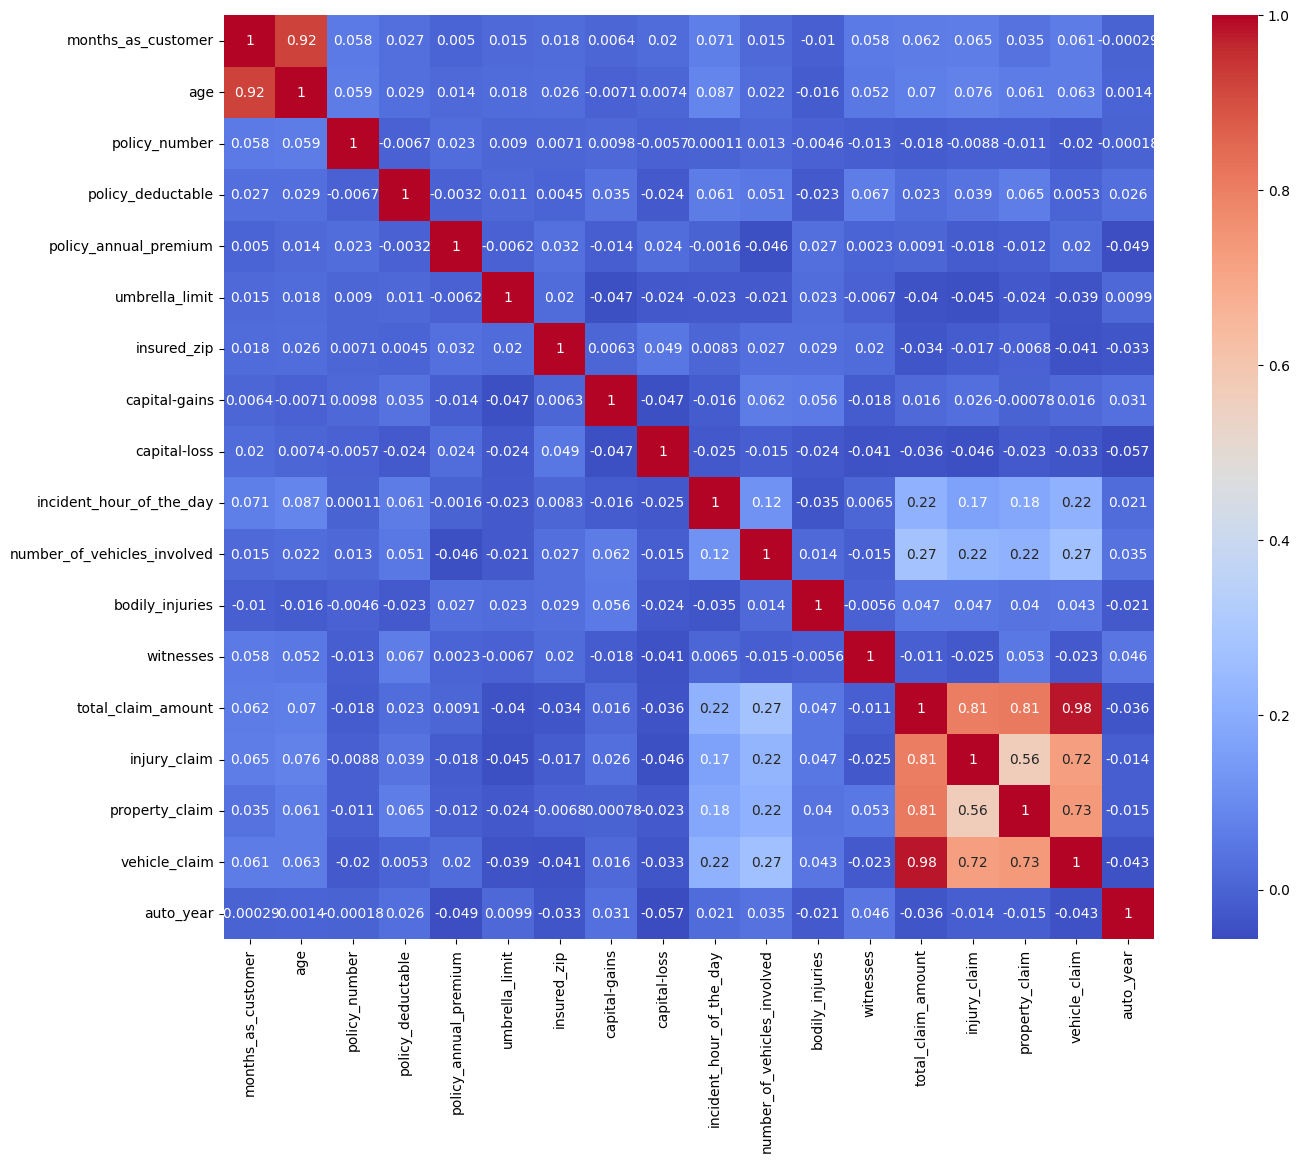

In [19]:
insu_data.plot_numeric_correlation()

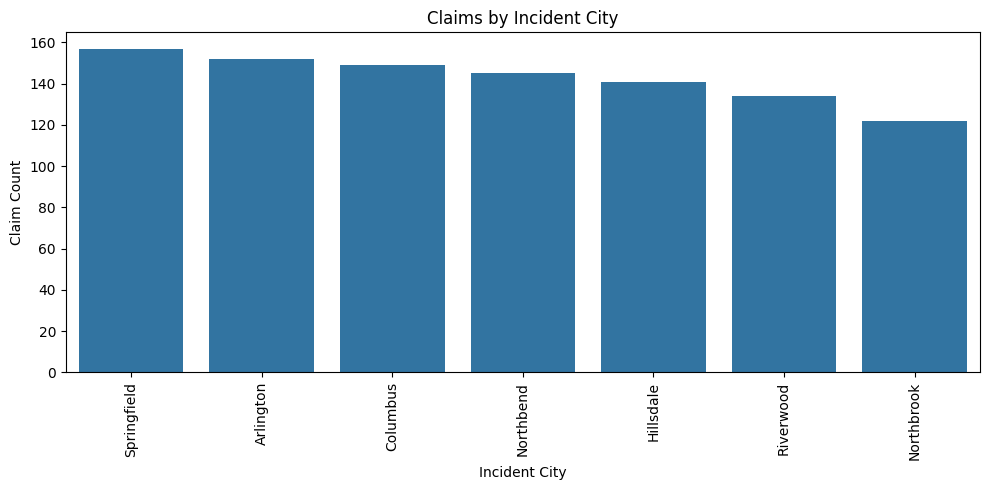

<Axes: title={'center': 'Claims by Incident City'}, xlabel='Incident City', ylabel='Claim Count'>

In [20]:
insu_data.bar_graph()

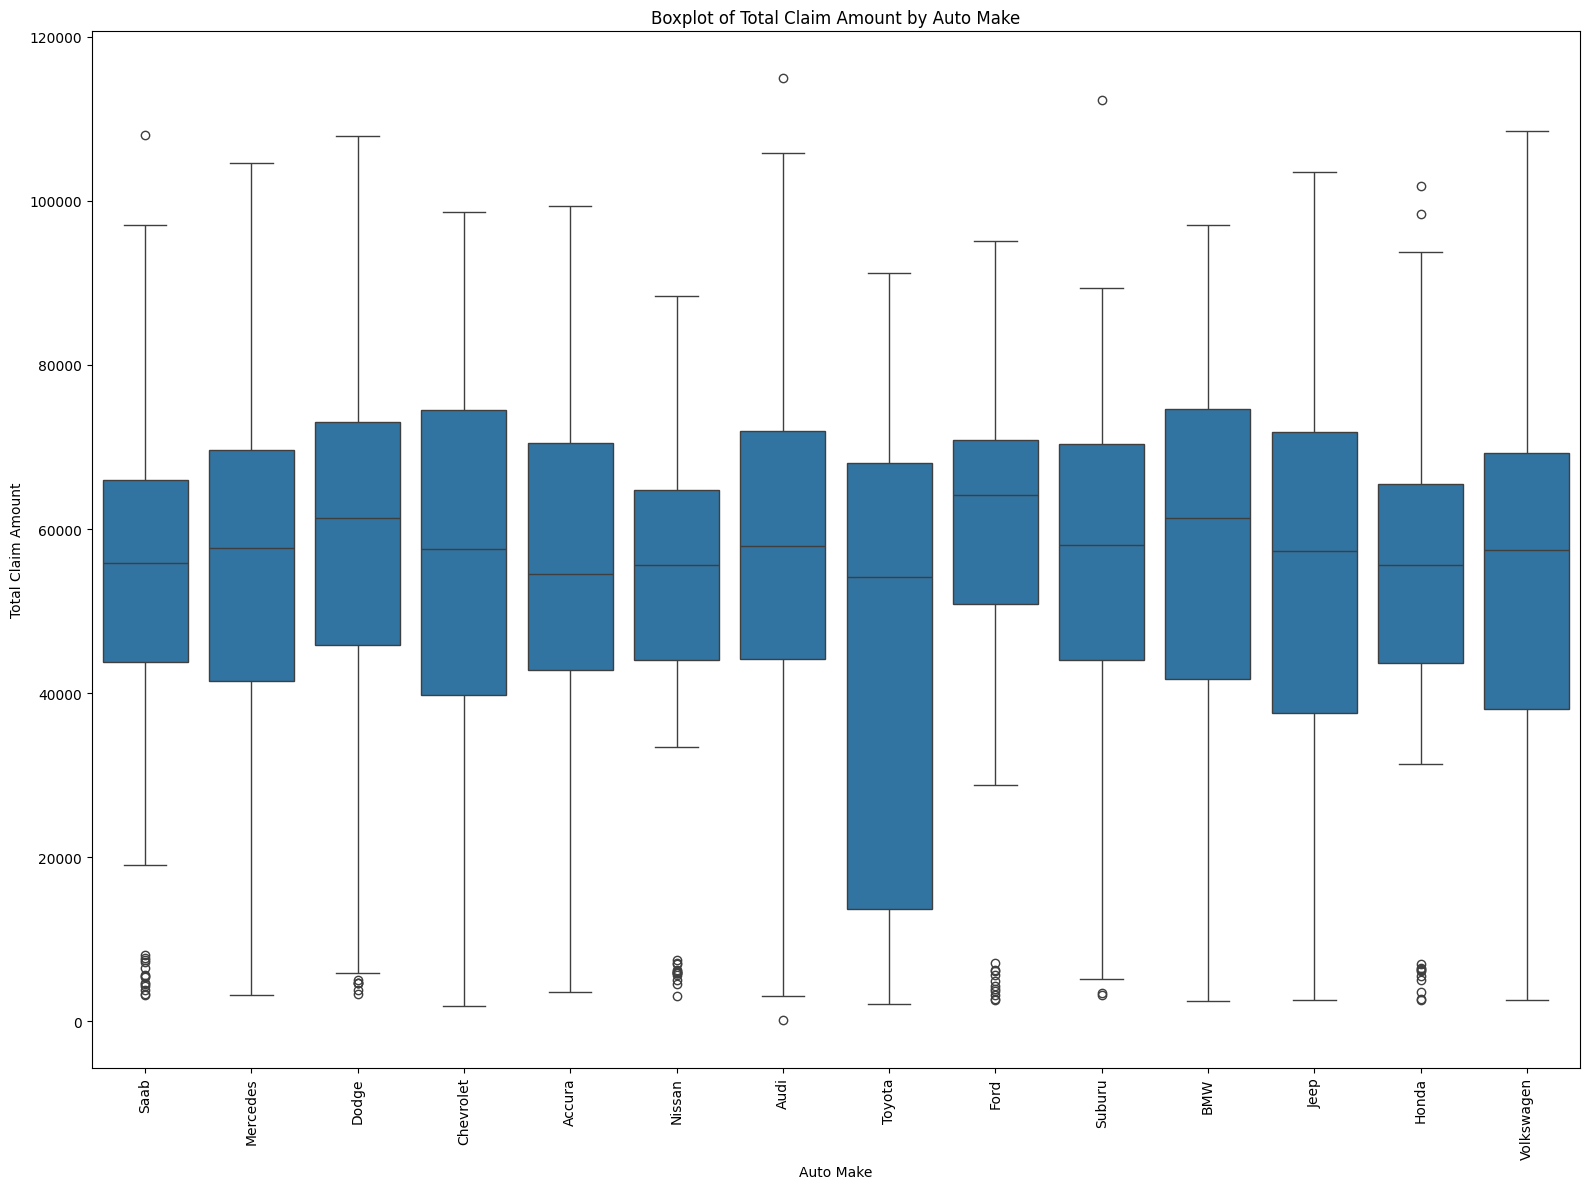

In [21]:
insu_data.plot_boxplot_auto_year_by_make()

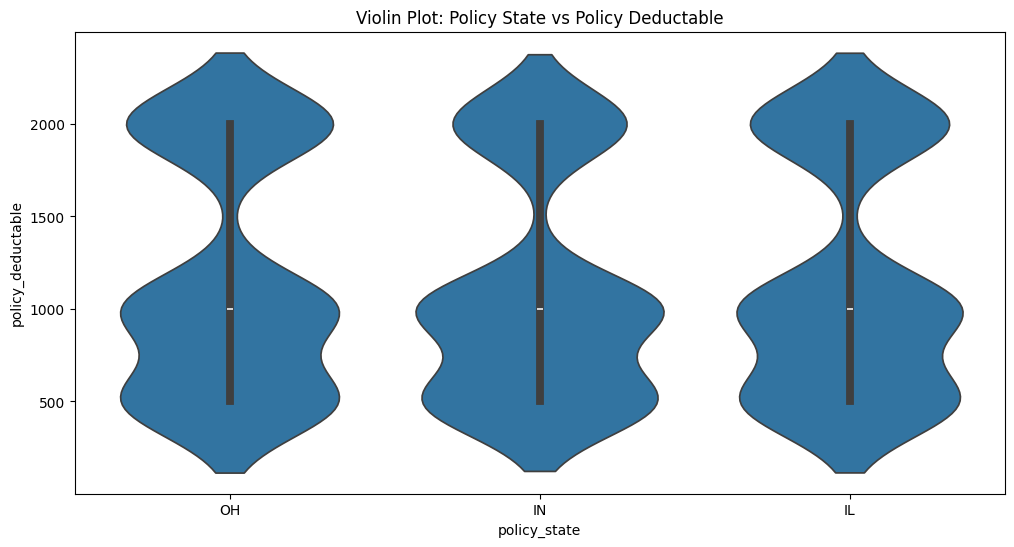

In [22]:
insu_data.plot_violin_policy_state_vs_deductable()

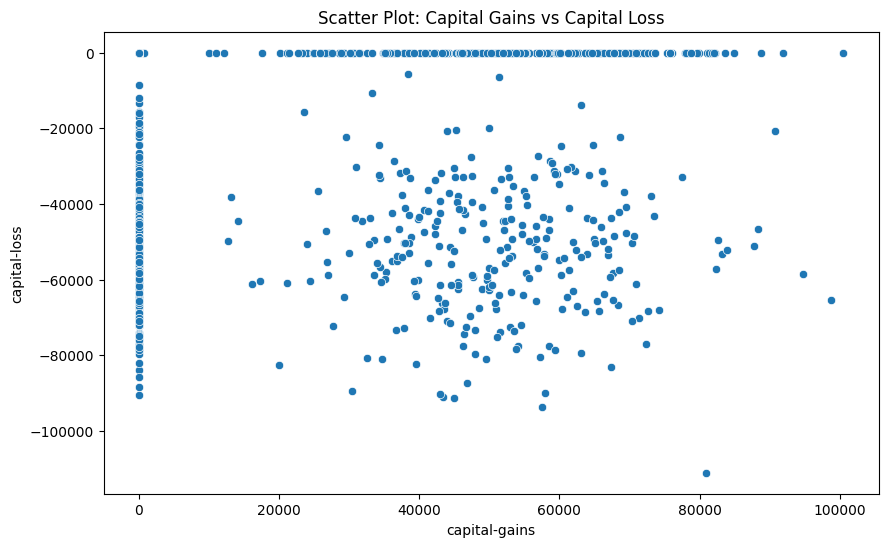

In [23]:
insu_data.plot_scatter_capital_gains_vs_loss()

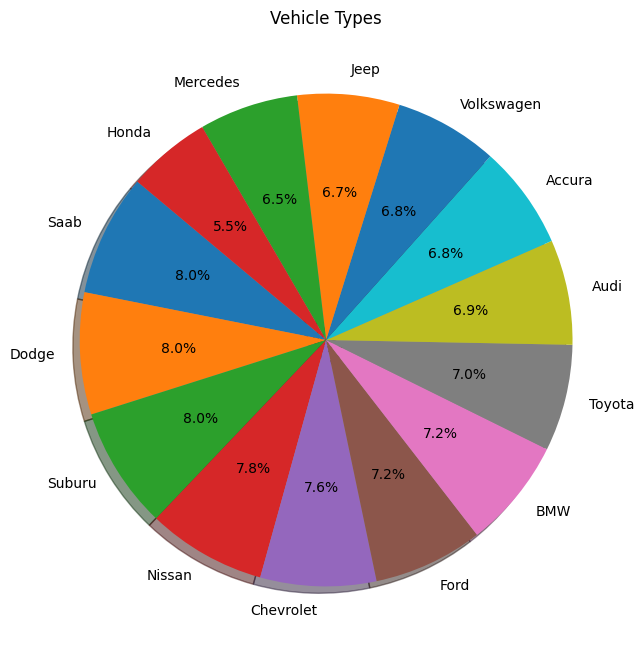

In [24]:
insu_data.plot_vehicle_make_pie()

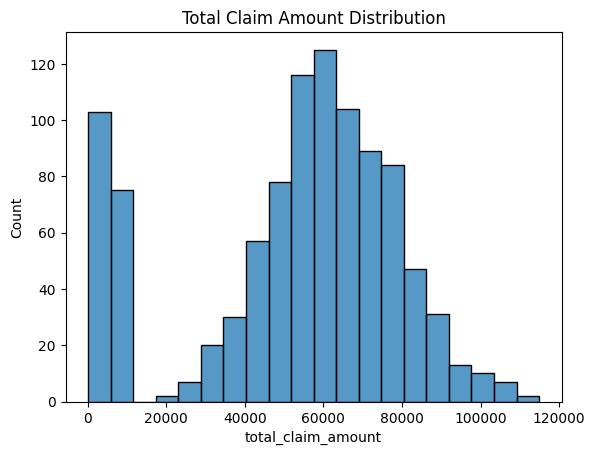

In [25]:
insu_data.histogram('total_claim_amount', title='Total Claim Amount Distribution')

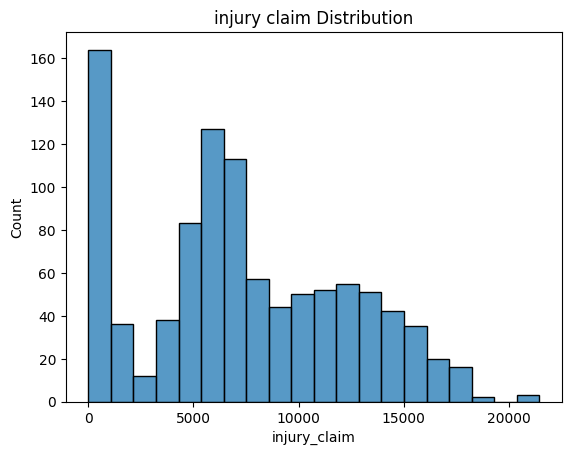

In [26]:
insu_data.histogram('injury_claim', title='injury claim Distribution')

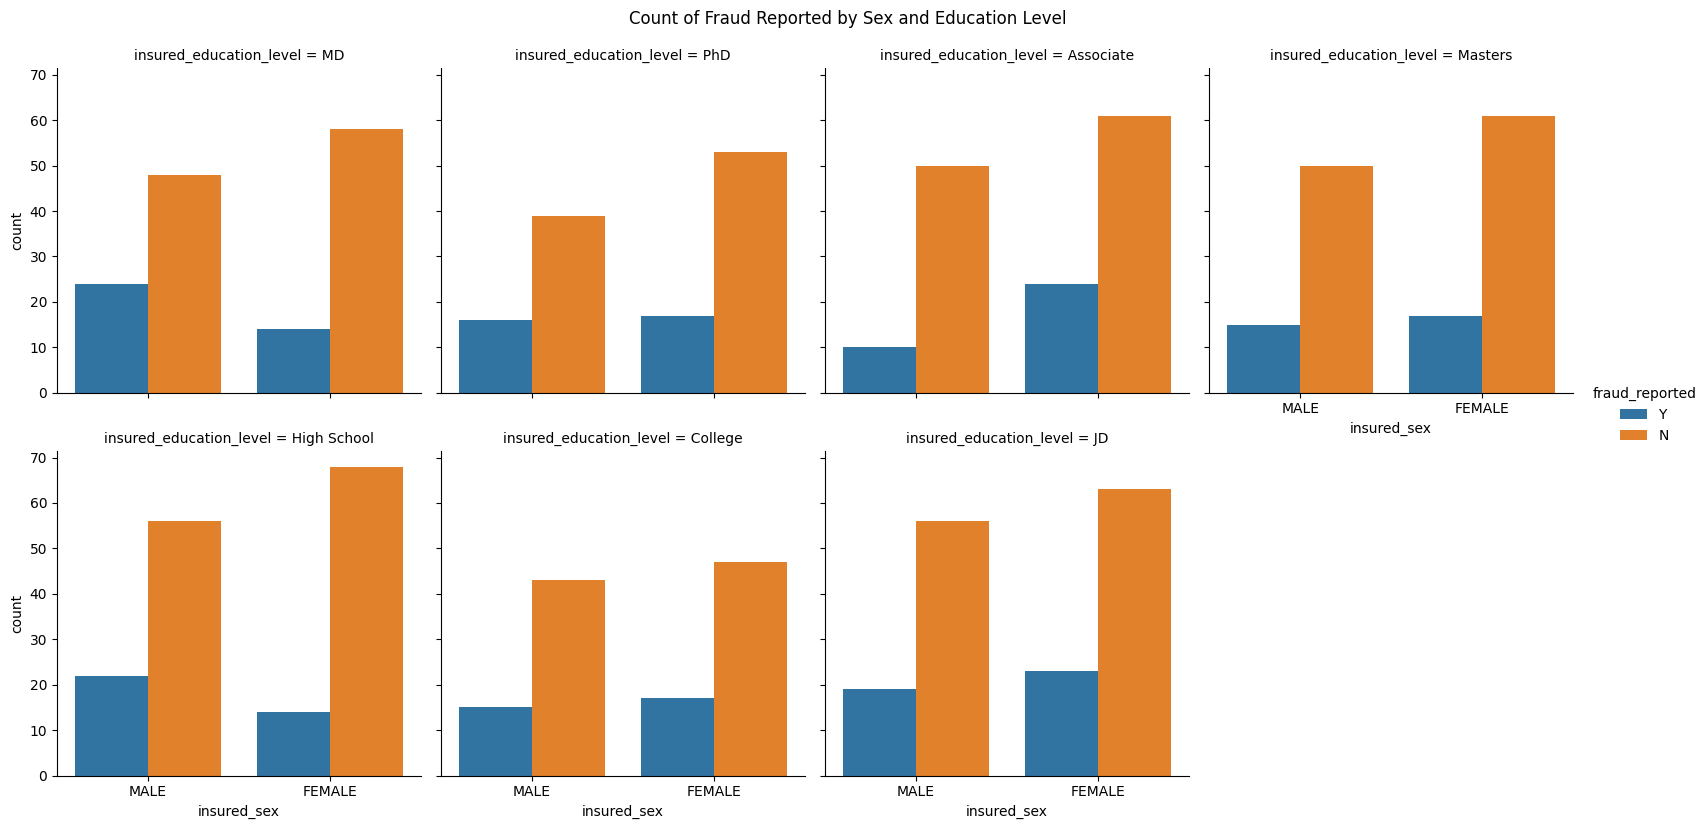

In [27]:
insu_data.plot_fraud_by_sex_and_education()

In [28]:
print(insu_data.generate_create_table_statement())


    CREATE TABLE IF NOT EXISTS insurance_claims (
        "months_as_customer" INT,
    "age" INT,
    "policy_number" INT,
    "policy_bind_date" TEXT,
    "policy_state" TEXT,
    "policy_csl" TEXT,
    "policy_deductable" INT,
    "policy_annual_premium" FLOAT,
    "umbrella_limit" INT,
    "insured_zip" INT,
    "insured_sex" TEXT,
    "insured_education_level" TEXT,
    "insured_occupation" TEXT,
    "insured_hobbies" TEXT,
    "insured_relationship" TEXT,
    "capital-gains" INT,
    "capital-loss" INT,
    "incident_date" TEXT,
    "incident_type" TEXT,
    "collision_type" TEXT,
    "incident_severity" TEXT,
    "authorities_contacted" TEXT,
    "incident_state" TEXT,
    "incident_city" TEXT,
    "incident_location" TEXT,
    "incident_hour_of_the_day" INT,
    "number_of_vehicles_involved" INT,
    "property_damage" TEXT,
    "bodily_injuries" INT,
    "witnesses" INT,
    "police_report_available" TEXT,
    "total_claim_amount" INT,
    "injury_claim" INT,
    "property_cla

In [30]:
conn_params = {
    'dbname': "postgres",
    'user': "postgres",
    'password': "901473R",
    'host': "localhost",
    'port': "5432"
}
insu_data.save_to_postgres(conn_params)

Data inserted successfully into table insurance_claims
